In [31]:

import sys
# sys.path.insert(1, '/BATTERY_GITHUB')
# import pre_process_utils

import BATTERY_GITHUB.pre_process_utils as pre_process_utils

import pandas as pd
import numpy as np
import h5py


from sklearn.preprocessing import MinMaxScaler
import scipy
import scipy.interpolate as interpolate

import matplotlib.pyplot as plt
params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)
from datetime import datetime


In [12]:
import importlib
importlib.reload(BATTERY_GITHUB.pre_process_utils)

<module 'BATTERY_GITHUB.pre_process_utils' from '/baja/BATTERY_GITHUB/pre_process_utils.py'>

# Set DIRS

In [13]:
DATA_DIR_  = 'Data/Battery/data'

# showcase data structure

In [14]:
#load battery RW3
specific_dir = DATA_DIR_ + '/Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab/'

raw_data = scipy.io.loadmat(specific_dir + 'RW3.mat')['data'][0][0][0][0]
raw_data = pd.DataFrame(raw_data)

In [15]:
raw_data.head()
# comment gives the stage of experiment
# divided into 2 stages
# 1. Reference curves : "reference charge" and "reference discharge"
# 2. RW walks: "discharge (random walk)", "rest (random walk)", "charge (random walk)" , "charge (after random walk discharge)"

,comment,type,time,relativeTime,voltage,current,temperature,date
0,[low current discharge at 0.04A],[D],"[[6503.410000000001, 6513.41, 6523.41, 6533.41...","[[0.15, 10.15, 20.15, 30.15, 40.15, 50.15, 60....","[[4.199, 4.195, 4.194, 4.194, 4.193, 4.193, 4....","[[0.0, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[[20.09833, 20.09833, 20.09833, 20.09833, 20.1...",[27-Dec-2013 16:30:13]
1,[reference charge],[C],"[[197686.53, 197696.53, 197706.53, 197716.53, ...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[3.397, 3.532, 3.599, 3.652, 3.696, 3.733, 3....","[[-2.002, -2.001, -2.0, -2.0, -2.0, -2.001, -1...","[[21.14174, 21.14174, 21.12617, 21.11059, 21.1...",[29-Dec-2013 21:36:39]
2,[reference discharge],[D],"[[208842.46, 208852.46, 208862.46000000002, 20...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.112, 4.095, 4.086, 4.079, 4.073, 4.068, 4....","[[1.005, 0.999, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0...","[[20.48766, 20.50323, 20.51881, 20.53438, 20.5...",[30-Dec-2013 00:42:36]
3,[reference charge],[C],"[[216075.45, 216085.45, 216095.44999999998, 21...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[3.524, 3.695, 3.744, 3.779, 3.807, 3.83, 3.8...","[[-2.006, -2.0, -2.0, -2.0, -2.001, -2.0, -2.0...","[[24.52113, 24.53671, 24.52113, 24.52113, 24.4...",[30-Dec-2013 02:43:10]
4,[reference discharge],[D],"[[226891.06, 226901.06, 226911.06, 226921.06, ...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.111, 4.094, 4.086, 4.078, 4.072, 4.067, 4....","[[1.003, 0.999, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0...","[[20.30078, 20.30078, 20.33193, 20.33193, 20.3...",[30-Dec-2013 05:43:27]


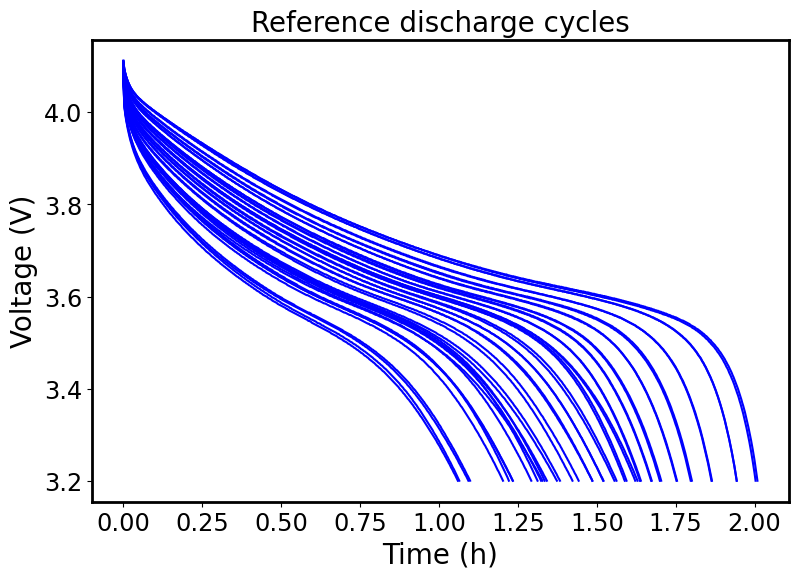

In [16]:
# Example reference discharges: 
data_voltage_discharge = raw_data[raw_data.comment == 'reference discharge']
for jj in range(len(data_voltage_discharge)):
    times = data_voltage_discharge.iloc[jj].time[0] - data_voltage_discharge.iloc[jj].time[0][0]
    plt.plot(times/3600,data_voltage_discharge.iloc[jj].voltage[0],'b')
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.title('Reference discharge cycles')
plt.show()

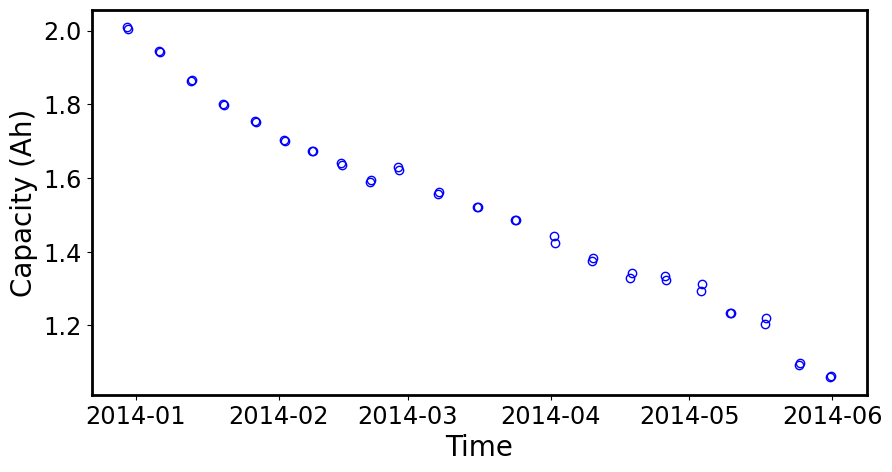

In [22]:
# Example how to calculate Capacity:
# Note that there are 2 reference experiments completed one after the other (sometimes they match and sometimes not)
fig = plt.figure(figsize=(10, 5))
real_HI = []
data_voltage_discharge = raw_data[raw_data.comment == 'reference discharge']
for jj in range(len(data_voltage_discharge)):
    times = data_voltage_discharge.iloc[jj].time[0] 
    current = data_voltage_discharge.iloc[jj].current[0]
    date = data_voltage_discharge.iloc[jj].date[0]
    date = datetime.strptime(date, '%d-%b-%Y %H:%M:%S')
    capacity = np.trapz(current,times)/3600
    real_HI.append(capacity)
    plt.plot(date,capacity,'bo',mfc='none',label = 'Capacity')

plt.ylabel('Capacity (Ah)') 
plt.xlabel('Time')
real_HI = np.array(real_HI)

# Load 1 battery

In [32]:
# Example of usage
specific_dir = DATA_DIR_ + '/Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab/'
curves = pre_process_utils.load_curves_discharge(specific_dir+'RW3.mat', RW=False,downsample_factor=2)

/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


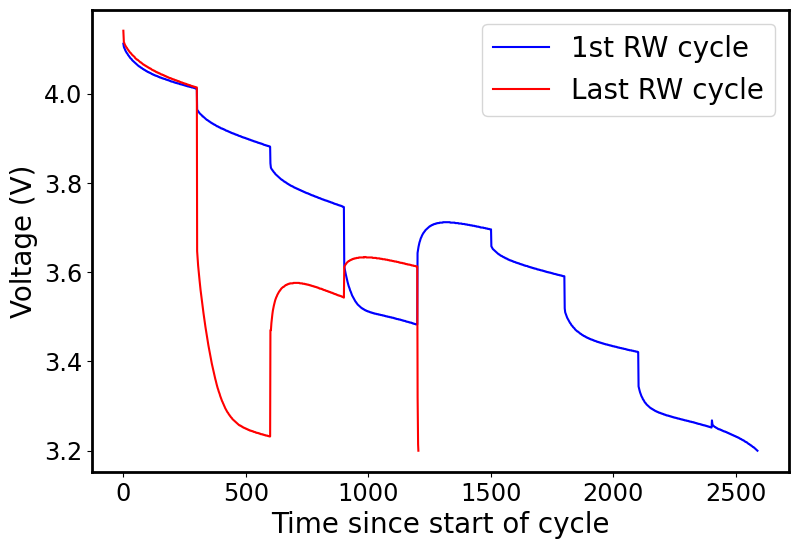

In [33]:
plt.plot(curves[0]['time']-curves[0]['time'][0],curves[0]['voltage'],'b',label = '1st RW cycle')
plt.plot(curves[-1]['time']-curves[-1]['time'][0],curves[-1]['voltage'],'r',label = 'Last RW cycle')
plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Time since start of cycle')
plt.show()

# Load all batteries

In [35]:
#All data is in train
# NOTE change downsample_factor = 2 to reproduce results of the paper

V_train,I_train,Temperature_train,C_train,C_train_2,U_train,HI_train,Energy_train,Time_train,\
V_test,I_test,Temperature_test,C_test,C_test_2,U_test,HI_test,Energy_test,Time_test, \
    battery_train_names,battery_test_names = pre_process_utils.load_all_data(dir=DATA_DIR_+'/',
    specific_dirs=[], train_test_split_mode=2,downsample_factor = 4)



LOADING DATA FROM: Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post
TRAIN BATTERIES: ['RW9.mat', 'RW12.mat', 'RW10.mat', 'RW11.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


452


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


527


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


537


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


563
LOADING DATA FROM: RW_Skewed_High_Room_Temp_DataSet_2Post
TRAIN BATTERIES: ['RW19.mat', 'RW20.mat', 'RW18.mat', 'RW17.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


596


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


626


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


583


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


617
LOADING DATA FROM: RW_Skewed_High_40C_DataSet_2Post
TRAIN BATTERIES: ['RW26.mat', 'RW27.mat', 'RW28.mat', 'RW25.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


458


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


519


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


460


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


449
LOADING DATA FROM: Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post
TRAIN BATTERIES: ['RW1.mat', 'RW7.mat', 'RW8.mat', 'RW2.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1054


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1130


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


979


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1037
LOADING DATA FROM: Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post
TRAIN BATTERIES: ['RW6.mat', 'RW5.mat', 'RW3.mat', 'RW4.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1027


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1056


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1076


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1012
LOADING DATA FROM: RW_Skewed_Low_Room_Temp_DataSet_2Post
TRAIN BATTERIES: ['RW13.mat', 'RW15.mat', 'RW16.mat', 'RW14.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1035


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


995


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1059


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1039
LOADING DATA FROM: RW_Skewed_Low_40C_DataSet_2Post
TRAIN BATTERIES: ['RW22.mat', 'RW23.mat', 'RW21.mat', 'RW24.mat']
TEST BATTERIES: []


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1013


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1099


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1038


/baja/BATTERY_GITHUB/pre_process_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['type'][raw_data['comment'].str.match('charge')] = 'C'


1022


In [ ]:
# Save data into one file:
np.savez(DATA_DIR_ + 'Load_data/loaded_data.npz',
V_train = V_train
I_train = V_train
Temperature_train = I_train
C_train = C_train
C_train_2 = C_train_2
U_train = U_train
HI_train = HI_train
Energy_train = Energy_train
Time_train = Time_train

# Prepocessing
***

## Split into train/test

In [36]:
# Other windows

data = np.load('Data/Battery/Load_data/loaded_data.npz')
V_train = data['V_train']
I_train = data['I_train']
Temperature_train = data['Temperature_train']
C_train = data['C_train']
C_train_2 = data['C_train_2']
U_train = data['U_train']
HI_train = data['HI_train']
Energy_train = data['Energy_train']
Time_train = data['Time_train']

sort_id = np.lexsort((C_train,U_train))
V_train = V_train[sort_id]
I_train = I_train[sort_id]
Temperature_train = Temperature_train[sort_id]
C_train = C_train[sort_id]
C_train_2 = C_train_2[sort_id]
U_train = U_train[sort_id]
HI_train = HI_train[sort_id]
Energy_train = Energy_train[sort_id]
Time_train = Time_train[sort_id]


# select only batteries with existing temperature data
non_valid_idx = np.ravel(Temperature_train<0)
non_valid_idx = np.unique(U_train[non_valid_idx])
valid_idx = np.ravel(~np.isin(U_train,non_valid_idx))

V_train = V_train[valid_idx]
I_train = I_train[valid_idx]
U_train = U_train[valid_idx]
Temperature_train = Temperature_train[valid_idx]
C_train = C_train[valid_idx]
C_train_2 = C_train_2[valid_idx]
HI_train = HI_train[valid_idx]
Time_train = Time_train[valid_idx]

#Large in sample experiment (remove 40C temperture)
U_train_select = [4,5,1,7,17,18,19,13,14,15]
U_test_select = [6,8,20,16]

# #OOD EXPERIMENT
# U_train_select = [1,4,5,6,7,8]
# U_test_select = [13,14,15,16,17,18,19,20]


idx_train = np.ravel(np.isin(U_train,U_train_select))
idx_test = np.ravel(np.isin(U_train,U_test_select))

V_test = V_train[idx_test]
I_test = I_train[idx_test]
U_test = U_train[idx_test]
Temperature_test = Temperature_train[idx_test]
C_test = C_train[idx_test]
C_test_2 = C_train_2[idx_test]
HI_test = HI_train[idx_test]
Time_test = Time_train[idx_test]

V_train = V_train[idx_train]
I_train = I_train[idx_train]
U_train = U_train[idx_train]
Temperature_train = Temperature_train[idx_train]
C_train = C_train[idx_train]
C_train_2 = C_train_2[idx_train]
HI_train = HI_train[idx_train]
Time_train = Time_train[idx_train]

In [37]:
print(V_train.shape,V_test.shape)

(5833257,) (2102702,)


## Interpolating capacity

Since Capacity is calculated every 50 RW cycle it makes sense to interpolate

In [38]:
HI_train = pre_process_utils.HI_interpolator(HI_train.reshape(-1,1),U_train.reshape(-1,1),C_train.reshape(-1,1),C_train_2.reshape(-1,1))
HI_test = pre_process_utils.HI_interpolator(HI_test.reshape(-1,1),U_test.reshape(-1,1),C_test.reshape(-1,1),C_test_2.reshape(-1,1))

## Cut data after a certain capacity threshold

In [39]:
Capacity_cut = 0.6
MANUFACTURE_CAPACITY = 2.1 

print('obs before cut, TR {}, TS {}'.format(V_train.shape[0],V_test.shape[0]))

V_train, I_train, Temperature_train,U_train,C_train,C_train_2,HI_train,Time_train = pre_process_utils.RUL_cut_all(
    V_train, I_train, Temperature_train,U_train,C_train,C_train_2,HI_train,Time_train,Capacity_cut,MANUFACTURE_CAPACITY)


V_test, I_test, Temperature_test,U_test,C_test,C_test_2,HI_test,Time_test = pre_process_utils.RUL_cut_all(
    V_test, I_test, Temperature_test,U_test,C_test,C_test_2,HI_test,Time_test,Capacity_cut,MANUFACTURE_CAPACITY)

print('obs after cut, TR {}, TS {}'.format(V_train.shape[0],V_test.shape[0]))

obs before cut, TR 5833257, TS 2102702
1.0 0.5594308035714286
4.0 0.5417596726190476
5.0 0.5394345238095238
7.0 0.5082775297619048
13.0 0.5203683035714286
14.0 0.4187593005952381
15.0 0.44689360119047616
17.0 0.5217633928571428
19.0 0.5119977678571428
6.0 0.6240699404761905
8.0 0.5147879464285714
16.0 0.46665736607142855
20.0 0.49572172619047616
obs after cut, TR 5336839, TS 1917824


## Scale

In [40]:
#Scale
scV = MinMaxScaler()
V_train = scV.fit_transform(V_train.reshape(-1,1))
scI = MinMaxScaler()
I_train = scI.fit_transform(I_train.reshape(-1,1))
scTemp = MinMaxScaler()
Temperature_train = scTemp.fit_transform(Temperature_train.reshape(-1,1))


V_test = scV.transform(V_test.reshape(-1,1))
I_test = scI.transform(I_test.reshape(-1,1))
Temperature_test = scTemp.transform(Temperature_test.reshape(-1,1))


## Scale capacity to SOH

In [41]:
HI_train = HI_train/MANUFACTURE_CAPACITY
HI_test = HI_test/MANUFACTURE_CAPACITY

## Windowing

### Partial window

In [42]:
pref_len = 200
stride = 10
Voltage_windows,Units_windows,Cycles_windows = pre_process_utils.sequence_generator(V_train,U_train,C_train,pref_len,stride)
Current_windows,_,_= pre_process_utils.sequence_generator(I_train,U_train,C_train,Voltage_windows.shape[1],stride)
Cycles_windows_2,_ ,_= pre_process_utils.sequence_generator(C_train_2.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1],stride)
HI_windows,_ ,_= pre_process_utils.sequence_generator(HI_train.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1],stride)
Temp_windows,_ ,_= pre_process_utils.sequence_generator(Temperature_train.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1],stride)
Time_windows,_,_ = pre_process_utils.sequence_generator(Time_train.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1],stride)



Voltage_windows_test,Units_windows_test,Cycles_windows_test = pre_process_utils.sequence_generator(V_test,U_test,C_test,Voltage_windows.shape[1],stride)
Current_windows_test,_ ,_= pre_process_utils.sequence_generator(I_test,U_test,C_test,Voltage_windows.shape[1],stride)
Cycles_windows_2_test,_ ,_= pre_process_utils.sequence_generator(C_test_2.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1],stride)
HI_windows_test,_ ,_= pre_process_utils.sequence_generator(HI_test.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1],stride)
Temp_windows_test,_ ,_= pre_process_utils.sequence_generator(Temperature_test.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1],stride)
Time_windows_test,_,_ = pre_process_utils.sequence_generator(Time_test.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1],stride)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2570 has 2 dimension(s)

In [ ]:
print(Voltage_windows.shape,Voltage_windows_test.shape)

### Full cycle widnow


In [43]:
pref_len = 2260
Voltage_windows,Cycles_windows,Units_windows = pre_process_utils.sequence_generator_full_trajectory(V_train,U_train,C_train,pref_len)
Current_windows,_ ,_= pre_process_utils.sequence_generator_full_trajectory(I_train,U_train,C_train,Voltage_windows.shape[1])
Cycles_windows_2,_ ,_= pre_process_utils.sequence_generator_full_trajectory(C_train_2.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1])
HI_windows,_ ,_= pre_process_utils.sequence_generator_full_trajectory(HI_train.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1])
Time_windows,_ ,_= pre_process_utils.sequence_generator_full_trajectory(Time_train.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1])
Temp_windows,_ ,_= pre_process_utils.sequence_generator_full_trajectory(Temperature_train.reshape(-1,1),U_train,C_train,Voltage_windows.shape[1])

Voltage_windows_test,Cycles_windows_test,Units_windows_test = pre_process_utils.sequence_generator_full_trajectory(V_test,U_test,C_test,Voltage_windows.shape[1])
Current_windows_test,_ ,_= pre_process_utils.sequence_generator_full_trajectory(I_test,U_test,C_test,Voltage_windows.shape[1])
Cycles_windows_2_test,_ ,_= pre_process_utils.sequence_generator_full_trajectory(C_test_2.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1])
HI_windows_test,_ ,_= pre_process_utils.sequence_generator_full_trajectory(HI_test.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1])
Time_windows_test,_ ,_= pre_process_utils.sequence_generator_full_trajectory(Time_test.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1])
Temp_windows_test,_ ,_= pre_process_utils.sequence_generator_full_trajectory(Temperature_test.reshape(-1,1),U_test,C_test,Voltage_windows.shape[1])

2260
2260
2260
2260
2260
2260
2260
2260
2260
2260
2260
2260


In [44]:
print(Voltage_windows.shape,Voltage_windows_test.shape)

(6474, 2260, 1) (2295, 2260, 1)


## Calculate RUL

In [ ]:
RUL_windows = pre_process_utils.RUL_maker(Cycles_windows,Units_windows).reshape(-1,1)
RUL_windows_test = pre_process_utils.RUL_maker(Cycles_windows_test,Units_windows_test).reshape(-1,1)

# Save data

In [ ]:
np.savez(DATA_DIR_ + '/Load_data/data_2260.npz', 
         Voltage_windows=Voltage_windows,Cycles_windows=Cycles_windows,Units_windows=Units_windows,
         Current_windows=Current_windows,Cycles_windows_2=Cycles_windows_2,
         HI_windows=HI_windows,Time_windows=Time_windows,
         Temp_windows=Temp_windows)

np.savez(DATA_DIR_ + '/Load_data/data_test_2260.npz', 
         Voltage_windows_test=Voltage_windows_test,Cycles_windows_test=Cycles_windows_test, Units_windows_test=Units_windows_test,
         Current_windows_test=Current_windows_test,Cycles_windows_2_test=Cycles_windows_2_test,
         HI_windows_test=HI_windows_test,Time_windows_test=Time_windows_test,
         Temp_windows_test=Temp_windows_test)